### Integrantes do Grupo

- Bruno Menegaz Acerbi - 2020101066 - bruno.m.acerbi@edu.ufes.br

- Gustavo Dutra Santolin - 2020100710 - gustavo.santolin@edu.ufes.br

- Lorenzo Miniguite Scaramussa - 2020100706 - lorenzo.scaramussa@edu.ufes.br

### Importando Bibliotecas

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
!pip install unidecode
import nltk
from nltk import word_tokenize
import string
import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importando Base de Dados

In [70]:
trainData = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/train_data.txt', sep=':::', engine='python',header=None)
testData = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/test_data_solution.txt', sep=':::', engine='python',header=None)
data = trainData.append(testData)
data = data.drop([0], axis=1)
data.columns = ['name', 'genre','description']

### ETL

In [71]:
data['genre'] = data['genre'].str.strip()

Filtrando base de dados para os gêneros selecionados

In [72]:
print("before filtering genres: ",len(data))
filter_list = ['drama', 'comedy', 'horror', 'thriller', 'action', 'mystery', 'sci-fi', 'fantasy', 'western', 'romance', 'music']
data = data[data['genre'].isin(filter_list)]
print("after filtering genres: ",len(data))

before filtering genres:  108414
after filtering genres:  59781


Criando os "super-gêneros" **h-t-m** (horro, thriller e mystery) e **s-f** (sci-fi e fantasy)

In [73]:
data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')
data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')

data = data.reset_index(drop=True)

<ipython-input-73-8a7e50b556ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')
<ipython-input-73-8a7e50b556ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')


In [74]:
#removendo possiveis valores nulos de descrição
data = data[data['description'].notna()]

### EDA

Visualização da quantidade de filmes em cada gênero, vemos uma grande quantidade em *drama* e *comedy*. Além disso nota-se que os gêneros *action*, *westem*, *s-f*, *music* e *romance* apresentam quantidades próximas

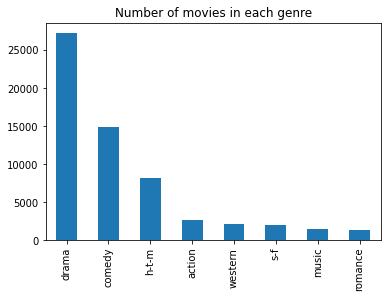

In [75]:
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

### Construção da Matriz TF-IDF

In [76]:
def criandoLinha(descrição):
    #capturando tokens da descrição
    tokens = word_tokenize(descrição)
    
    #normalizando para minúsculo
    tokens = [w.lower() for w in tokens]

    #removendo simbolos de pontuação
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

    #tratando caracteres especiais
    tokens = [unidecode.unidecode(w) for w in tokens]

    #selecionando apenas palavras
    words = [word for word in tokens if word.isalpha()]

    #removendo palavras com 3 ou menos caracteres
    words = [word for word in words if len(word) > 3]

    #removendo palavras vazias
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    #redução de palavras
    porter = PorterStemmer()
    stemmedWords = [porter.stem(word) for word in words] 

    n = 2
    ngrams = []
    for i in range(len(words)-n+1):
        ngram = " ".join(words[i:i+n])
        ngrams.append(ngram)

    #transformando lista de stemmedWords em uma string
    stringTerms = ' '.join(stemmedWords)



    return stringTerms

In [77]:
#criando a lista de strings de termos
listStringTerms = data['description'].apply(criandoLinha)

In [78]:
#construindo matriz TF-IDF excluindo termos que aparecem em menos de 5 títulos
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(listStringTerms)
X

<59781x20988 sparse matrix of type '<class 'numpy.float64'>'
	with 2492125 stored elements in Compressed Sparse Row format>

### Redução Utilizando SDV

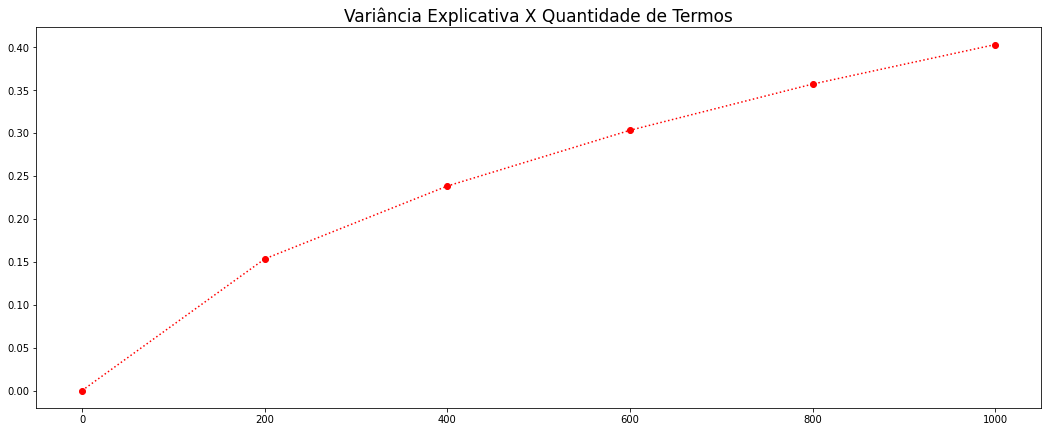

In [11]:
listVarianciaExplicativa = []

for n in range(0, 1200, 200):
    X_svd = TruncatedSVD(n_components=n)
    lsa = X_svd.fit(X)
    listVarianciaExplicativa.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(18, 7))
plt.title('Variância Explicativa X Quantidade de Termos', fontsize = 17);
plt.plot(range(0, 1200, 200), listVarianciaExplicativa, 'ro:')

A partir desse gráfico, pode-se visualizar que a redução não consegue capturar bem os dados originais e muito se perde à medida que diminuímos a quantidade de termos. Outra característica notável é o comportamento logarítmico da curva, o que dificulta a escolha de um ponto ideal. Dessa forma decidimos por maximizar a variância explicativa utilizando **1000** termos para o nosso primeiro agrupamento. Essa escolha foi possível já que implementou-se o *K-Means*, um agrupamento "barato".

Para os demais casos, decidiu-se utilizar o valor de **200** termos por se tratar de um ponto de destaque na curva, uma vez que, após ele, pouco é o ganho obtido.

In [79]:
svd = TruncatedSVD(n_components=1000, random_state=3)
X_svd = svd.fit_transform(X)

In [80]:
svd.explained_variance_ratio_.sum()

0.4030615082599081

### Agrupamentos

#### Funções Auxiliares

In [81]:
# Função para gerar um novo dataSet a partir de um tamanho máximo de filmes. Respeitando as proporcionalidade contidas nele.

def reduzDadosProporcionalmente(tamanhoSample):
  totalMovies = data['genre'].value_counts()
  total = 0
  listPesos = [0,0,0,0,0,0,0,0]
  genreList = ['drama', 'comedy','h-t-m','action','s-f','western','romance','music']

  for i in totalMovies:
    total += i

  for i in range(0,8):
    listPesos[i] = data['genre'].value_counts()[genreList[i]]/total


  newQtdMoviesByGeng = []
  for i in range(0,8):
    newQtdMoviesByGeng.append(round(tamanhoSample*listPesos[i]))

  listNewDf = []
  for i in range(0,8):
    df = data[data['genre'] == genreList[i]]
    df = df.sample(newQtdMoviesByGeng[i])

    listNewDf.append(df)

  for i in range(1,len(listNewDf)):
    listNewDf[0] = listNewDf[0].append(listNewDf[i])

  newData = listNewDf[0]
  newData = newData.reset_index(drop=True)
  
  return newData


In [82]:
# Função para capturar a proporcionalidade de filmes de cada gênero em um grupo específico #
## Essa proporcionalidade é baseada no total de filmes presentes no dataSet que deu origem ao grupo ##

def genreByGroup(grupo, listTotalMovie, data):
  contList = [0,0,0,0,0,0,0,0]
  genreList = ['drama', 'comedy','h-t-m','action','s-f','western','romance','music']

  for row in grupo.index:
      genreGroup = data.loc[row]['genre']
      for i in range(0,len(genreList)):
        if genreList[i] == genreGroup:
          contList[i] += 1

  for i in range(0,8):
    contList[i] = contList[i]/listTotalMovie[genreList[i]]


  return genreList, contList

#### Dendrograma

Para dar início aos agrupamentos, decidimos plotar um Dendrograma para nos guiar com a escolha da quantidade de grupos a serem criados. 

Para realizar essa tarefa era necessário diminuir o dataset, uma vez que a memória RAM disponível no ambiente de execução não era suficiente para a execução sob todos os dados iniciais. Sendo assim foi criada uma função capaz de realizar essa redução respeitando as proporções originais do dataSet inicial. A partir daí, tornou-se possível a construção do Dendrograma.

In [53]:
denData = reduzDadosProporcionalmente(5000)

#criando a lista de strings de termos
denListStringTerms = denData['description'].apply(criandoLinha)

##construindo matriz TF-IDF
denNectorizer = TfidfVectorizer(min_df = 5)
denX = denNectorizer.fit_transform(denListStringTerms)
denX

<5000x5339 sparse matrix of type '<class 'numpy.float64'>'
	with 190716 stored elements in Compressed Sparse Row format>

In [54]:
denSvd = TruncatedSVD(n_components=200, random_state=3)
denX_svd = denSvd.fit_transform(denX)

In [55]:
denSvd.explained_variance_ratio_.sum()

0.24401946521236884

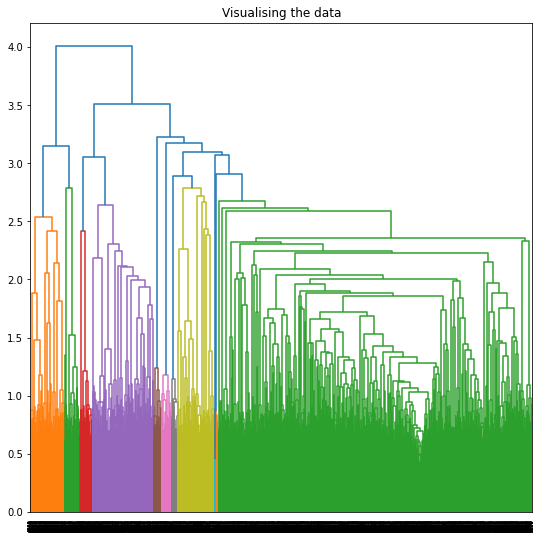

In [58]:
plt.figure(figsize =(9, 9))
plt.title('Visualising the data')
Dendrogram = hierarchy.dendrogram((hierarchy.linkage(denX_svd, method ='ward')))

#### K-MEANS

O K-MEANS foi o primeiro agrupamento escolhido devido ao seu menor custo de execução. Para determinarmos a quantidade de grupos a ser passada como parâmetro de sua chamada, utilizamos o Dendrograma desenvolvido anteriormente. 

Uma vez que a divisão dos grupos não se dava de forma clara e "limpa", onde grupos com tamanhos muito discrepantes eram criados, decidimos implementar uma abordagem em que fragmentávamos o DataSet para a confecção de 3 agrupamentos distintos. Esses 3 agrupamentos podem ser visualizados na imagem abaixo, onde cada linha horizontal representa um agrupamento que foi realizado.

Para o **1°** agrupamento foram criados 3 grupos.

Para o **2°** foram criados 5 grupos.

E para o **3°** agrupamento foram criados 3 grupos.

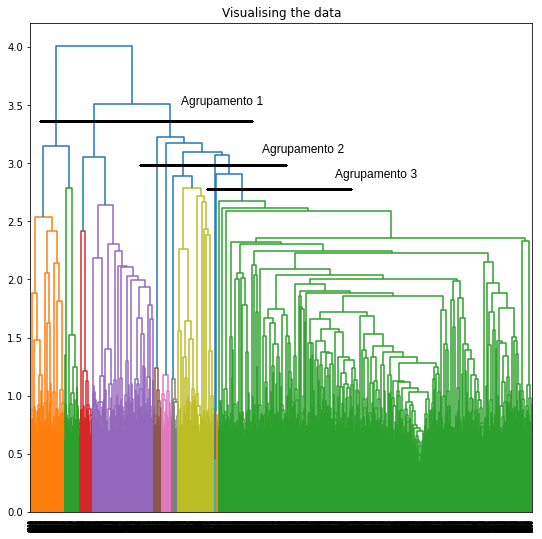

##### Primeiro Agrupamento

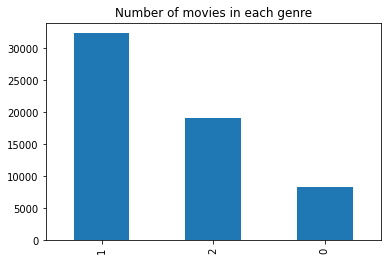

In [83]:
kmeans = KMeans(n_clusters=3, random_state=45).fit(X_svd)
y_kmeans = kmeans.predict(X_svd)

pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [84]:
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])

totalMovies = data['genre'].value_counts()
grupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
grupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
grupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]

drama      27225
comedy     14893
h-t-m       8226
action      2629
western     2064
s-f         1938
music       1462
romance     1344
Name: genre, dtype: int64

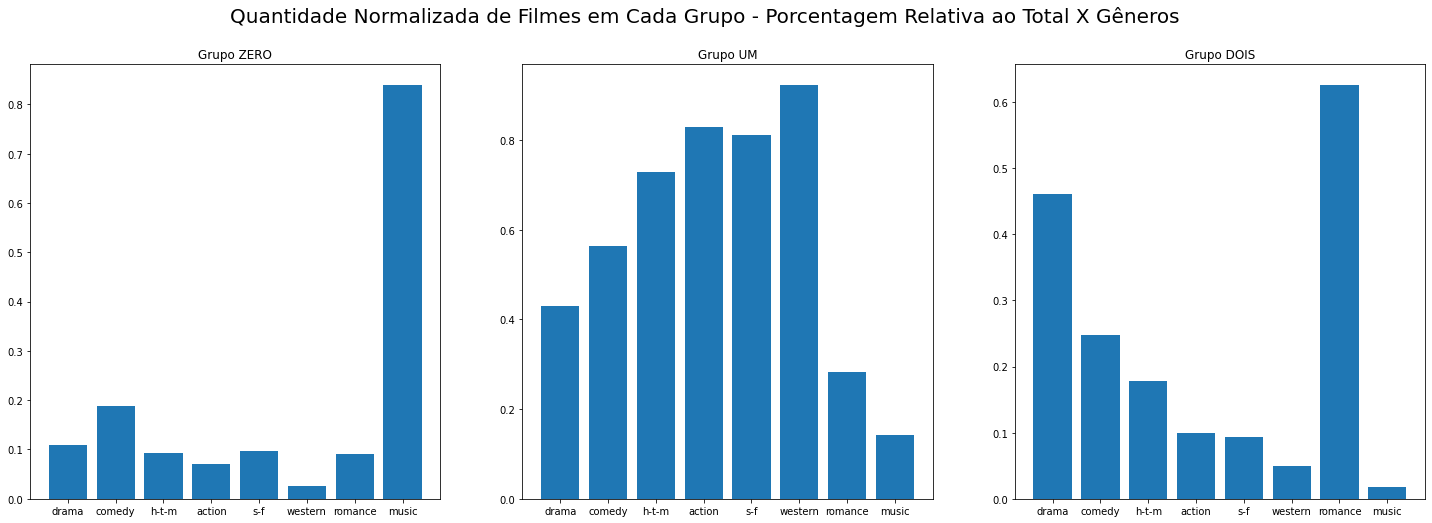

In [85]:
zeroX, zeroY = genreByGroup(grupoZero,totalMovies,data)
umX, umY = genreByGroup(grupoUm,totalMovies,data)
doisX, doisY = genreByGroup(grupoDois,totalMovies,data)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
fig.suptitle('Quantidade Normalizada de Filmes em Cada Grupo - Porcentagem Relativa ao Total X Gêneros', fontsize = 20)

ax1.bar(zeroX, zeroY)
ax1.set_title('Grupo ZERO')

ax2.bar(umX, umY)
ax2.set_title('Grupo UM')

ax3.bar(doisX, doisY)
ax3.set_title('Grupo DOIS')

totalMovies

Visualizamos, de início, a presença de um grupo muito discrepante, no qual aproximadamente **80%** dos **1462** títulos de música são inclusos, esse é o *grupo_ZERO*. Além dessa grande quantidade de musicais, vemos a baixa presença dos demais gêneros nesse grupo, uma média aproximada de **10%**, ou seja, o gênero música destoa bastante dos demais gêneros e pode ser facilmente agrupado.

Dando sequência, vemos uma tendência de agrupamento para o *grupo_DOIS*, onde aproximadamente **60%** dos **1344** filmes de romance são inclusos, porém há uma presença muito forte dos filmes de drama, cerca de **45%** dos **27225** filmes desse gênero estão presentes. Outro detalhe que se nota é a presença de **25%** dos **14893** filmes de comédia nesse mesmo grupo. Tal comportamento faz muito sentido quando analisamos a realidade, uma vez que filmes de romance estão muito próximos a filmes de drama, como também estão muito próximos de comédias, haja vista o subgênero comédia romântica.

Por último olhamos o *grupo_UM*, nesse agrupamento nenhum gênero se destacou dos demais, mas vale ressaltar que a maior parte dos filmes presentes no dataSet foram inclusos nele, mais de **30000** títulos. Sendo assim, decidimos realizar um novo agrupamento, porém agora somente com os filmes que foram direcionados ao *grupo_UM*.

##### Segundo Agrupamento

In [90]:
## Criando um novo DataFrame relativo aos títulos presentes no grupo_UM

subData = data.loc[grupoUm.index.tolist()]
subX_svd = X_svd[subData.index]

subData = subData.reset_index(drop=True)

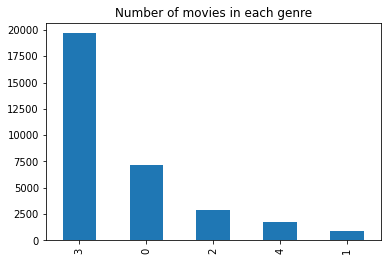

In [107]:
kmeans = KMeans(n_clusters=5, random_state=45).fit(subX_svd)
y_kmeans = kmeans.predict(subX_svd)

pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [108]:
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])

subTotalMovies = subData['genre'].value_counts()
subGrupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
subGrupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
subGrupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]
subGrupoTres = y_kmeans_df[y_kmeans_df['genre'] == 3]
subGrupoQuatro = y_kmeans_df[y_kmeans_df['genre'] == 4]

drama      11687
comedy      8410
h-t-m       5999
action      2179
western     1907
s-f         1571
romance      380
music        207
Name: genre, dtype: int64

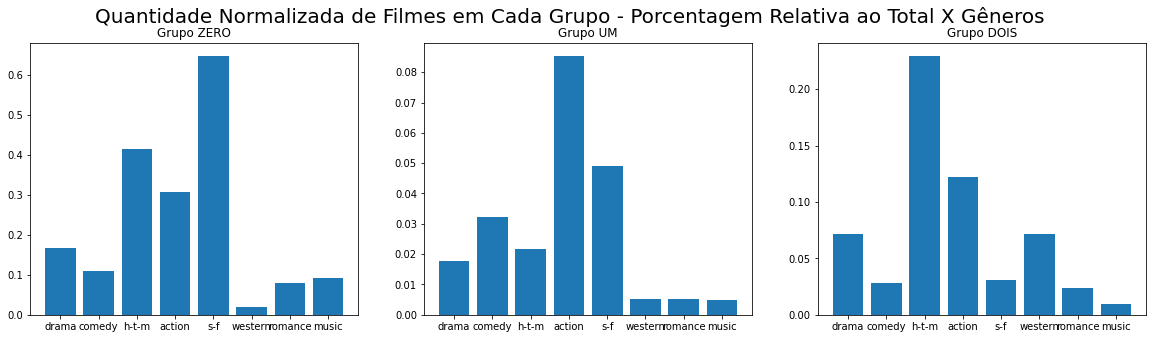

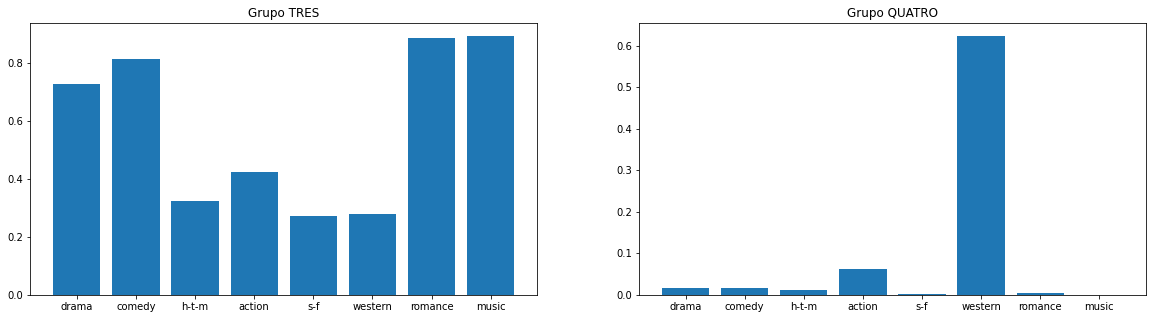

In [109]:
zeroX, zeroY = genreByGroup(subGrupoZero,subTotalMovies,subData)
umX, umY = genreByGroup(subGrupoUm,subTotalMovies,subData)
doisX, doisY = genreByGroup(subGrupoDois,subTotalMovies,subData)
tresX, tresY = genreByGroup(subGrupoTres,subTotalMovies,subData)
quatroX, quatroY = genreByGroup(subGrupoQuatro,subTotalMovies,subData)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Quantidade Normalizada de Filmes em Cada Grupo - Porcentagem Relativa ao Total X Gêneros', fontsize = 20)

ax1.bar(zeroX, zeroY)
ax1.set_title('Grupo ZERO')

ax2.bar(umX, umY)
ax2.set_title('Grupo UM')

ax3.bar(doisX, doisY)
ax3.set_title('Grupo DOIS')

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20,5))
ax4.bar(tresX, tresY)
ax4.set_title('Grupo TRES')

ax5.bar(quatroX, quatroY)
ax5.set_title('Grupo QUATRO')

subTotalMovies

Novamente, vemos a presença de um grupo que se destaca dos demais, sendo este o *grupo_QUATRO*, no qual cerca de **60%** dos **1907** filmes de *western* estão presentes. Além dessa forte presença desse gênero, nota-se a baixíssima presença dos demais gêneros, sendo o gênero *action* o único que apresenta valores maiores que **5%**, aproximando-se de **10%**. Tal comportamento faz sentido, visto que filmes de velho-oeste são conhecidos pela ação presente neles.

Seguimos para o próximo grupo que chama a atenção, sendo esse o *grupo_DOIS*. Nele vemos uma tendência à aparição de filmes do gênero *h-t-m*, porém os valores não são tão altos. Cerca de **25%** dos **5999** títulos desse gênero estão presentes nesse grupo. Mesmo com essa presença mais baixa, pode-se dizer que há um agrupamento semi-satisfatório, já que a presença de filmes de outros gênero é bem baixa. Somente *action* consegue chegar em valores maiores, **12%**, o que, novamente, faz bastante sentido quando analisamos a realidade.

Vemos um caso similar no *grupo_ZERO*, onde mais de **60%** dos 1571 filmes do gênero *s-f* foram alocados, porém nota-se uma grande presença de ruído nesse grupo, uma vez que os gêneros *h-t-m* e *action* também tiveram grande representatividade, **40%** e **30%**, respectivamente.

Com relação ao *grupo_UM* vemos uma peculiaridade, já que foram poucos os filmes alocados nesse grupo. Vemos uma predominância do gênero *action*, mas com apenas **8%** de representatividade com relação ao seu total. Entretanto, nota-se que nenhum dos demais gêneros consegue se aproximar muito, exceção apenas de *s-f*, haja vista a proximidade entre os gêneros quando analisamos a realidade.

Partindo para o último grupo, o *grupo_TRES*,vemos que a maior parte dos filmes foram direcionados a ele, cerca de **20000** dos aproximados **30000** filmes selecionados, ou seja, há uma dificuldade por parte do algoritmo em direcionar esses títulos a grupos específicos. 

Novamente iremos tentar achar grupos dentro do subGrupo *grupo_TRES*.

##### Terceiro Agrupamento

In [110]:
## Criando um nodo DataFrame relativo aos títulos presentes no subGrupo_TRES

sub_subData = subData.loc[subGrupoTres.index.tolist()]
sub_subX_svd = X_svd[sub_subData.index]

sub_subData = sub_subData.reset_index(drop=True)

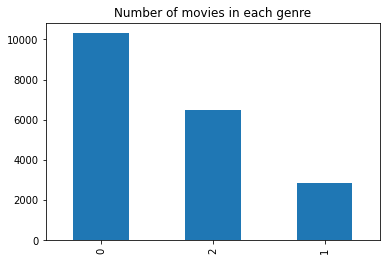

In [111]:
kmeans = KMeans(n_clusters=3, random_state=45).fit(sub_subX_svd)
y_kmeans = kmeans.predict(sub_subX_svd)

pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [112]:
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])

sub_subTotalMovies = sub_subData['genre'].value_counts()
sub_subGrupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
sub_subGrupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
sub_subGrupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]

Text(0.5, 1.0, 'Grupo DOIS')

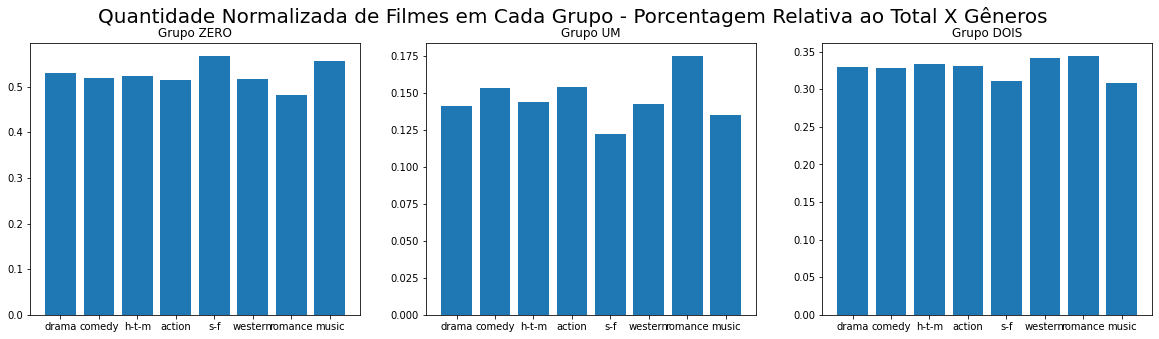

In [113]:
zeroX, zeroY = genreByGroup(sub_subGrupoZero,sub_subTotalMovies,sub_subData)
umX, umY = genreByGroup(sub_subGrupoUm,sub_subTotalMovies,sub_subData)
doisX, doisY = genreByGroup(sub_subGrupoDois,sub_subTotalMovies,sub_subData)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20.11,5))
fig.suptitle('Quantidade Normalizada de Filmes em Cada Grupo - Porcentagem Relativa ao Total X Gêneros', fontsize = 20)

ax1.bar(zeroX, zeroY)
ax1.set_title('Grupo ZERO')

ax2.bar(umX, umY)
ax2.set_title('Grupo UM')

ax3.bar(doisX, doisY)
ax3.set_title('Grupo DOIS')

Chegamos em um fim...


Com essa nova subdivisão vemos que já haviamos encontrado o máximo de grupos divisíveis, uma vez que nenhum gênero destaca-se sob os demais em nenhum dos grupos.

#### Agrupamento Hierárquico

In [31]:
data['genre'].value_counts(normalize=True)

drama      0.455412
comedy     0.249126
h-t-m      0.137602
action     0.043977
western    0.034526
s-f        0.032418
music      0.024456
romance    0.022482
Name: genre, dtype: float64

Há uma grande discrepância nas proporções dos gêneros dentro da classes. Drama, por exemplo, ocupa quase metade dos dados totais (45%), o que pode gerar um viés no modelo. Para contornar isso, vamos aplicar um undersample para balancear as classes, atribuindo a cada uma delas um peso igual ao inverso da proporção de filmes que ela possui.

In [32]:
#definindo proporções arbitrariamente
weights ={'drama': 0.3, 'comedy': 0.3, 'h-t-m': 0.2, 'action': 1, 'western': 1, 'romance': 1, 'music': 1, 's-f': 1}
weights

{'drama': 0.3,
 'comedy': 0.3,
 'h-t-m': 0.2,
 'action': 1,
 'western': 1,
 'romance': 1,
 'music': 1,
 's-f': 1}

In [33]:
#ressample data to balance classes and reduce dataset size using weights
data_r = data.groupby('genre', group_keys=False).apply(lambda x: x.sample(frac=weights[x.name], random_state=3))

#reduce propocionally, the dataset 
data_r = data_r.sample(frac=0.5, random_state=3)
data_r

,name,genre,description
28474,Moment to Moment (1975),comedy,"An experimental, ludicrous, plotless, absurd,..."
48549,"""Will It Snow at Christmas?"" (2009)",romance,"Cha Kang Jin is the son of barmaid, Cha Chun ..."
28774,Skulduggery (1989),drama,Four lads decide to meet up and do a robbery ...
56759,Donavon Frankenreiter: The Abbey Road Session...,music,"Filmed in the famous Abbey Road studios, this..."
11615,Satan's Harvest (1970),action,When his uncle is killed in a horrible animal...
...,...,...,...
3106,Five Bold Women (1960),western,Marshal Kirk Reed is escorting five female pr...
51620,"""Despertar contigo"" (2016)",romance,Pablo Herminio loves being a bodyguard. When ...
30492,The Perfect Stranger (2005),drama,'THE PERFECT STRANGER' tells the story of Nik...
18228,Roadman (2010),h-t-m,"To his neighbours and workmates, Max Greif is..."


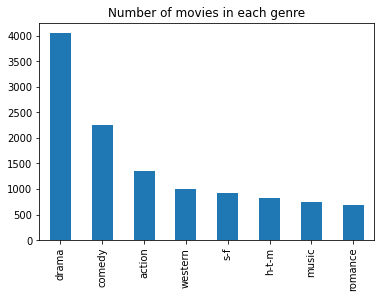

In [34]:
data_r['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

In [35]:
listStringTerms = data_r['description'].apply(criandoLinha)

In [36]:
##construindo matriz TF-IDF
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(listStringTerms)
X

<11859x8976 sparse matrix of type '<class 'numpy.float64'>'
	with 472356 stored elements in Compressed Sparse Row format>

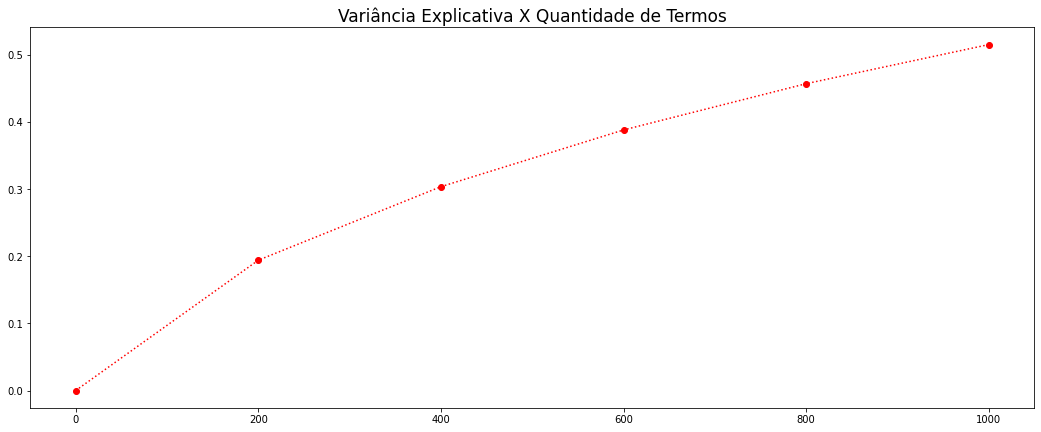

In [37]:
listVarianciaExplicativa = []

for n in range(0, 1200, 200):
    X_svd = TruncatedSVD(n_components=n)
    lsa = X_svd.fit(X)
    listVarianciaExplicativa.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(18, 7))
plt.title('Variância Explicativa X Quantidade de Termos', fontsize = 17);
plt.plot(range(0, 1200, 200), listVarianciaExplicativa, 'ro:')

In [38]:
#calcula o maior gradiente entre o número de componentes aplicados
maxGradient = 0
maxGradientIndex = 0
for i in range(1, len(listVarianciaExplicativa)):
    gradient = listVarianciaExplicativa[i] - listVarianciaExplicativa[i-1]
    if gradient > maxGradient:
        maxGradient = gradient
        maxGradientIndex = i
print(maxGradient)
print(maxGradientIndex)

0.19420278362174392
1


Pela análise do gráfico e, também, do maior gradiente, escolheremos 200 como o número de componentes ideal para aplicar o SVD.

In [39]:
svd = TruncatedSVD(n_components=200, random_state=3)
X_svd = svd.fit_transform(X)

##### Análise de dendrogramas

É interessante que analisemos, antes que seja feito um agrupamento hierárquico, vários dendrogramas considerando números diferentes de grupos e métodos diferentes de linkages. Dessa forma, poderemos escolher agrupar utilizando a estratégia que defina melhor os grupos.

Dendrograma hierárquico, linkage "complete" com 6 grupos


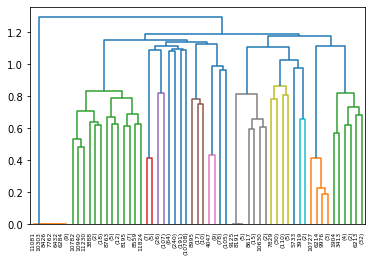

In [40]:
hierarquia_1 = hierarchy.linkage(X_svd, method='complete')
hierarchy.dendrogram(hierarquia_1,p=6,truncate_mode="level")
plt.show()

Dendrograma hierárquico, linkage "complete" com 3 grupos


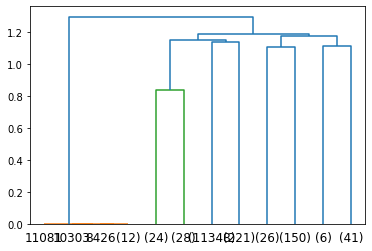

In [41]:
hierarquia_2 = hierarchy.linkage(X_svd, method='complete')
hierarchy.dendrogram(hierarquia_2,p=3,truncate_mode="level")
plt.show()

Dendrograma hierárquico, linkage "ward" com 6 grupos



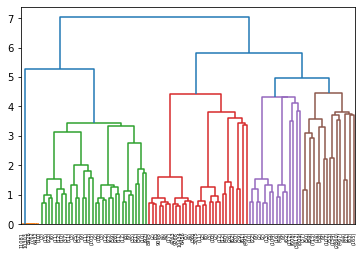

In [42]:
hierarquia_3 = hierarchy.linkage(X_svd, method='ward')
hierarchy.dendrogram(hierarquia_3,p=6,truncate_mode="level")
plt.show()

Dendrograma hierárquico, linkage "ward" com 3 grupos

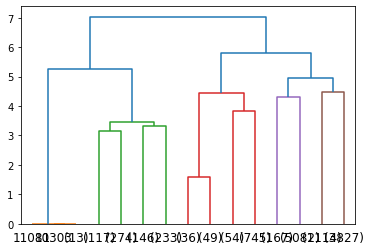

In [43]:
agrup_hie_complete = hierarchy.linkage(X_svd, method='ward')
hierarchy.dendrogram(agrup_hie_complete,p=3,truncate_mode="level")
plt.show()

Dendrograma hierárquico, linkage "average" com 3 grupos


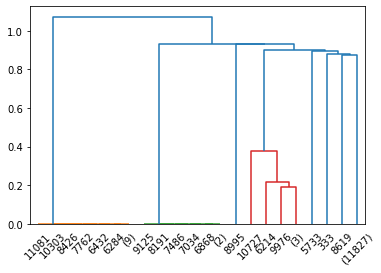

In [44]:
agrup_hie_complete = hierarchy.linkage(X_svd, method='average')
hierarchy.dendrogram(agrup_hie_complete,p=6,truncate_mode="level")
plt.show()

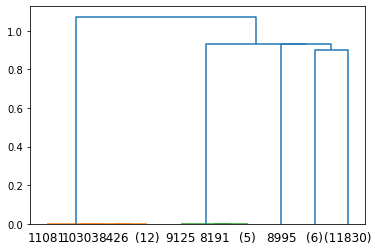

In [45]:
agrup_hie_complete = hierarchy.linkage(X_svd, method='average')
hierarchy.dendrogram(agrup_hie_complete,p=3,truncate_mode="level")
plt.show()

##### AgglomerativeClustering

Vamos aplicar o AgglomerativeClustering com o método "ward" considerando 6 clusters

In [46]:
hierarquico_6 = AgglomerativeClustering(6, linkage = 'ward')
hierarquico_6.fit(X_svd);
print(np.unique(hierarquico_6.labels_, return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([ 884, 5249, 3827,   15,  770, 1114]))


In [47]:
totalMovies = data_r['genre'].value_counts()

In [48]:
df_hie = pd.DataFrame(hierarquico_6.labels_, columns=['genre'])
grupos_6 = [ df_hie[df_hie['genre'] == i] for i in range(0,6)]


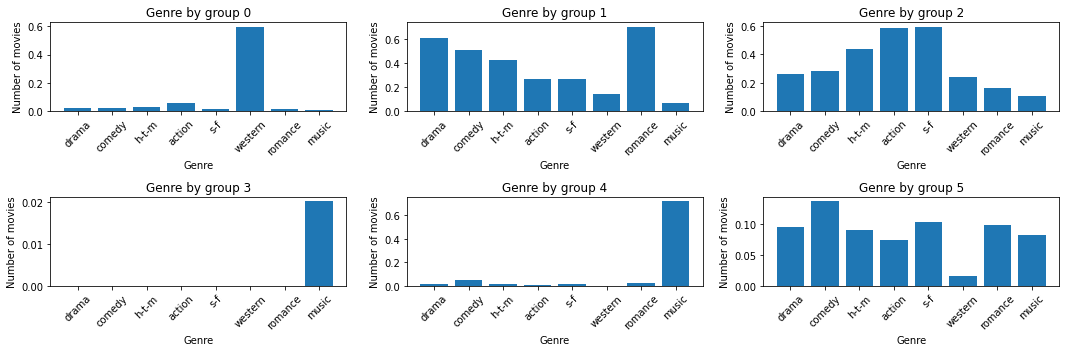

In [49]:
fig, ax = plt.subplots(2,3, figsize=(15,5))
for i in range(0,6):
      genreList,listCont = genreByGroup(grupos_6[i],totalMovies,data_r.reset_index())
      ax[i//3,i%3].bar(genreList,listCont)
      ax[i//3,i%3].set_title('Genre by group')
      ax[i//3,i%3].set_xlabel('Genre')
      ax[i//3,i%3].set_ylabel('Number of movies')
      ax[i//3,i%3].set_title('Genre by group ' + str(i))
      ax[i//3,i%3].set_xticklabels(genreList, rotation=45)
fig.tight_layout()
plt.show()


Pela análise do gráfico, nota-se que há uma distinção clara para classes "western" e "music" mas, para outras, não há como agrupar de forma clara. Assim, agruparemos em 3 clusters com o objetivo de colocar "music", "western" e os demais em respectivos grupos 

In [50]:
hierarquico = AgglomerativeClustering(3, linkage = 'ward')
hierarquico.fit(X_svd);
print(np.unique(hierarquico.labels_, return_counts=True))

(array([0, 1, 2]), array([  785, 10190,   884]))


In [51]:
df_hie = pd.DataFrame(hierarquico.labels_, columns=['genre'])
grupos = [ df_hie[df_hie['genre'] == i] for i in range(0,6)]

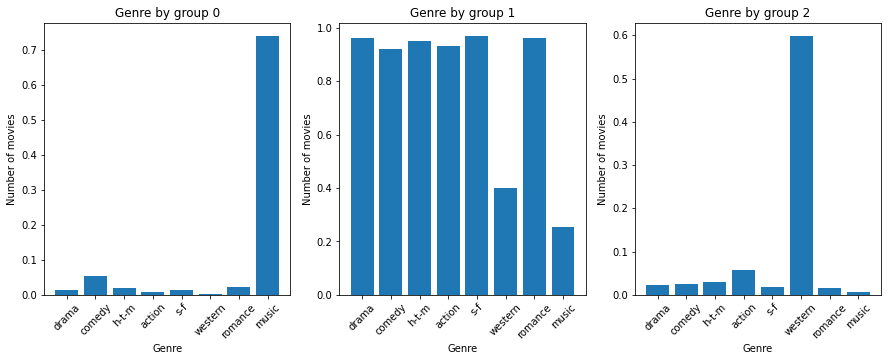

In [52]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(0,3):
      genreList,listCont = genreByGroup(grupos[i],totalMovies,data_r.reset_index())
      ax[i].bar(genreList,listCont)
      ax[i].set_title('Genre by group')
      ax[i].set_xlabel('Genre')
      ax[i].set_ylabel('Number of movies')
      ax[i].set_title('Genre by group ' + str(i))
      ax[i].set_xticklabels(genreList, rotation=45)

plt.show()


Com esse novo agrupamento, é possível dizer que os filmes de "Music" e "Western" possuem características distintivas dos demais suficientes para criar grupos isolados dos demais. Mesmo assim, ainda há 40% dos dados de "Westem" e 30% dos dados de "Music" presentes.

---



### Conclusão

De modo geral, os dados do IMDB de filmes não geram padrões de agrupamento muito efetivos para a realização de agrupamentos com o objetivo de distinguir gêneros de filmes baseados somente em suas descrições. Pelo menos com os métodos utilizados, não houve como representar todos os gêneros em grupos.

A redução de dimensionalidades para a aplicação nos modelos de agrupamento, possibilitando sua execução em tempo hábil, reduz muito a informação representada pelas descrições, o que pode ser um dos fatores que limita o modelo de identificar padrões dentro dos dados.

Apesar disso, conseguimos separar boa parte dos filmes de gênero "western" e "music" utilizando o método de agrupamento hierárquico através da análise de diversos perfis de abordagem desse método de agrupamento.

Ao analisarmos a aplicação do K-Means, vemos que ela foi a abordagem com os melhores resultados, visto que conseguiu, ou distinguir gêneros muitos discrepantes, ou agrupar filmes que, ao analisarmos a realidade, fazem sentido de serem agrupados juntos, uma vez que seus gêneros são próximos ou acabam coexistindo em uma mesma obra, considerando a presença de gêneros genéricos como *drama* e *action* na base de dados.